# 1D simulation of a valley glacier

This notebook creates and runs a one-dimensional simulation model of a hypothetical valley glacier.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

The block below defines the code for the model:

In [2]:
class ValleyGlacierSimulator(object):

    def __init__(self,
                 valley_length=10000.0,
                 valley_slope=0.1,
                 ela=900.0,
                 gamma=0.01,
                 flow_law_coefficient=6.8e-24,
                 ice_density=850.0,
                 sliding_factor=0.0,
                 grav_accel=9.8,
                 num_nodes=50,
                 timestep_duration=0.04,
                ):
        """Initialize the ValleyGlacierSimulator.

        Parameters
        ----------
        valley_length: float
            Length of valley, m (default 10 km)
        valley_slope: float
            Valley slope gradient, m/m
        ela: float
            Equilibrium line altitude, m (default 900)
        gamma: float
            Mass balance coefficient, 1/yr (default 0.01)
        flow_law_coefficient: float
            "A" in flow law, s^-1 Pa^-3 (default 6.8 x 10^-24)
            (Note: 6.8 x 10^-24 s^-1 Pa^-3 ~ 2 x 10^-16 yr^-1 Pa^3)
        ice_density: float
            Bulk density of glacial ice, kg/m3 (default 850)
        sliding_factor: float
            Sliding speed as proportion of deformation speed (default 0)
        grav_accel: float
            Gravitational acceleration (default 9.8)
        num_nodes: int
            Number of nodes (default 50)
        timestep_duration: float
            Duration of a time step, yr (default 0.04)
        """
        self.valley_length = valley_length
        self.valley_slope = valley_slope
        self.ela = ela
        self.gamma = gamma
        self.flow_law_coefficient = flow_law_coefficient
        self.ice_density = ice_density
        self.sliding_factor = sliding_factor
        self.g = grav_accel
        self.timestep_duration = timestep_duration
        self.dx = valley_length / (num_nodes - 1)
        
        self.current_time = 0.0

        self.x = np.linspace(0.5 * self.dx, 
                             valley_length - 0.5 * self.dx,
                             num_nodes)
        self.x_edges = np.linspace(0, valley_length, num_nodes + 1)
        zmax = self.valley_slope * self.valley_length
        self.z = zmax - self.valley_slope * self.x
        self.ice_thickness = np.zeros(num_nodes)
        self.q = np.zeros(num_nodes + 1)
        self.ice_slope = np.zeros(num_nodes)
        self.ice_slope[-1] = valley_slope
        self.b = gamma * (self.z - ela)

        self.Hstar = 0.01  # depth decay scale for melt rate, m
        
        # Calculate lumped parameter in flow law: U = k H^4, in m/(s m4)
        #
        # The units here are: 
        #   A => 1 / s Pa3 (= m3 s5 / kg3)
        #   rho_ice => kg / m3
        #   g => m / s2
        #
        # Therefore A (rho_ice g)^3 => m3 s5 kg3 m3 / kg3 m9 s6 => 1 / m3 s
        # and k_sec H^4 => m4 / m3 s => m / s
        # and k H^4 => m4 s / m3 s yr => m / yr
        #
        k_sec = (0.4 * flow_law_coefficient * (1 + sliding_factor)
                 * (ice_density * grav_accel)**3)  
        self.k = k_sec * 3600 * 24 * 365.25; # To per-year from per-sec


    def run_one_step(self):
        """Advance for one time step"""
        #print('Time = ' + str(self.current_time))
        self.ice_slope[:-1] = -(np.diff(self.ice_thickness + self.z)
                                / self.dx)
        self.q[1:] = self.k * self.ice_slope**3 * self.ice_thickness**5
        dqdx = np.diff(self.q) / self.dx  # flux gradient, m/yr
        self.b[:] = self.gamma * ((self.z + self.ice_thickness) - self.ela)
        b_eff = self.b  # effective net accum rate, m/yr
        below_ela = self.b < 0
        b_eff[below_ela] = (self.b[below_ela]
                            * (1 - np.exp(-self.ice_thickness[below_ela]
                                          / self.Hstar)))
        dHdt = b_eff - dqdx  # mass balance
        self.ice_thickness += dHdt * self.timestep_duration
        self.ice_thickness = np.maximum(self.ice_thickness, 0.0)
        self.current_time += self.timestep_duration

    def run_n_steps(self, n):
        for i in range(n):
            self.run_one_step()


The function below initializes and runs the model, and generates and displays and animation of the result. Here, we are using default parameters:

In [3]:
def run_model(run_duration=1000.0,
              valley_length=10000.0,
              valley_slope=0.1,
              ela=900.0,
              gamma=0.01,
              flow_law_coefficient=6.8e-24,
              ice_density=850.0,
              sliding_factor=0.0,
              grav_accel=9.8,
              num_nodes=50,
              timestep_duration=0.04,
              save_every=400,
             ):
    """Initialize, run, and display output from model.

    Parameters
    ----------
    run_duration: float
        Number of years to run (default 1200)
    save_every: int
        Interval to save an animation frame, in iterations (default 5)
    (see ValleyGlacierSimulator for other parameters)
    """

    # Instantiate and initialize a simulator
    model = ValleyGlacierSimulator(valley_length=valley_length,
                                   valley_slope=valley_slope,
                                   ela=ela,
                                   gamma=gamma,
                                   flow_law_coefficient=flow_law_coefficient,
                                   ice_density=ice_density,
                                   sliding_factor=sliding_factor,
                                   grav_accel=grav_accel,
                                   num_nodes=num_nodes,
                                   timestep_duration=timestep_duration
                                  )

    # Calculate number of animation iterations
    nsteps = int(run_duration / (model.timestep_duration * save_every))

    # Set up a blank figure with placeholder lists for data
    fig, ax = plt.subplots()
    xdata = []
    ydata = []
    obj = ax.plot([], [], color = 'k')

    # Then, set up an initialization function
    def init():
        ax.set_ylim(0, 2 * np.amax(model.z))
        ax.set_xlim(0, model.valley_length)
        ax.set_ylabel('Height (m)')
        ax.set_xlabel('Distance (m)')
        return(obj)

    # Next, define the update function
    def update(i):
        ax.cla()
        model.run_n_steps(save_every)
        xdata = model.x
        ydata = model.z
        ax.set_ylim(0, 2 * np.amax(model.z))
        ax.set_xlim(0, model.valley_length)
        ax.set_ylabel('Height (m)')
        ax.set_xlabel('Distance (m)')
        ax.set_title('Time = ' + str(round(model.current_time)) + ' years')
        ax.text(0.05 * model.valley_length, 1.8 * np.amax(model.z), 'ACCUMULATION')
        ax.text(0.82 * model.valley_length, 0.25 * np.amax(model.z), 'ABLATION')
        ax.text(0.9 * model.valley_length, 1.02 * model.ela, 'ELA')
        obj = ax.plot(xdata, ydata + model.ice_thickness, color='c')
        obj = ax.plot(xdata, ydata, color='k')
        obj = ax.plot([0.0, model.valley_length], [model.ela, model.ela], 'm:')
        return(obj)

    def report_values(model):
        """Report values of various quantities."""
        print('Final glacier length: ' + str(model.dx 
                                             * np.count_nonzero(model.ice_thickness > 0.0))
              + ' m')
        print('Final maximum thickness: ' + str(np.amax(model.ice_thickness)) + ' m')
        qq = model.q[1:]
        u = 0 * qq
        ice_present = model.ice_thickness > 0.0
        u[ice_present] = qq[ice_present] / model.ice_thickness[ice_present]
        print('Final maximum velocity: ' + str(np.amax(u)) + ' m/yr')
        print('Final maximum ice specific discharge: ' + str(np.amax(qq)) + ' m2/yr')    # Clean up the model
        print('Final ice volume (per width): ' + str(model.dx * np.sum(model.ice_thickness))
              + ' m2')
        
    # Run the animation!
    anim = FuncAnimation(fig, update, nsteps, init_func=init, blit = True)
    
    # Convert the animation to HTML
    vid = HTML(anim.to_html5_video())  # or HTML(anim.to_jshtml())

    report_values(model)

    return vid, model

## An example model run with default parameters

Final glacier length: 4489.795918367347 m
Final maximum thickness: 137.39192847354875 m
Final maximum velocity: 21.206158955519324 m/yr
Final maximum ice specific discharge: 2772.1593490089804 m2/yr
Final ice volume (per width): 510275.0183689234 m2


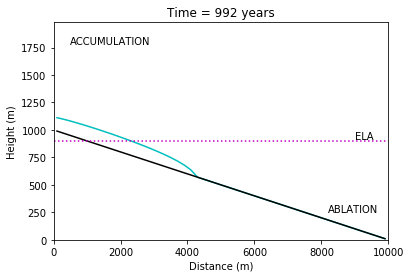

In [4]:
my_movie, model = run_model()
my_movie

## An example model run with a different ELA

Final glacier length: 8571.428571428572 m
Final maximum thickness: 177.6064788995503 m
Final maximum velocity: 51.88137193542978 m/yr
Final maximum ice specific discharge: 9014.244782377906 m2/yr
Final ice volume (per width): 1267471.8860927522 m2


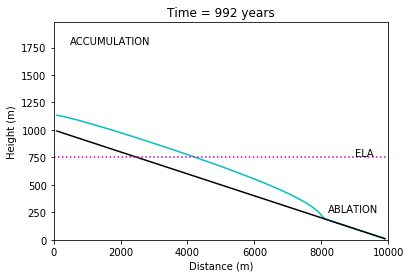

In [5]:
my_movie, model = run_model(ela=750.0)
my_movie

## Example of plotting the ice thickness discharge

The `model` data object contains arrays for ice thickness and discharge at the end of the run. To plot ice thickness, use the `model.x` array for the locations of the model cells and the `model.ice_thickness` for the ice thickness at those locations:

Text(0, 0.5, 'Thickness (m)')

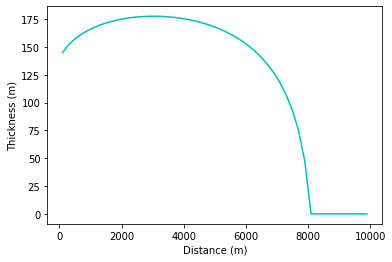

In [6]:
plt.plot(model.x, model.ice_thickness, 'c')
plt.xlabel('Distance (m)')
plt.ylabel('Thickness (m)')

To plot ice discharge, use `model.x_edges` (the locations of the *edges* of the cells) and `model.q`, which is the ice discharge calculated *at the cell edges*.

Text(0, 0.5, 'Specific ice discharge (m2/yr)')

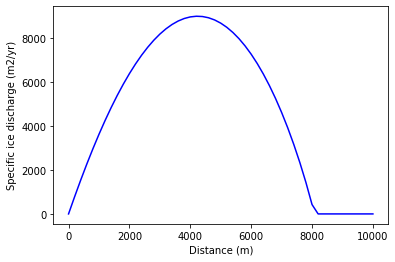

In [7]:
plt.plot(model.x_edges, model.q, 'b')
plt.xlabel('Distance (m)')
plt.ylabel('Specific ice discharge (m2/yr)')

## Your turn

Use the cells below to experiment with running the model with different parameters and/or boundary conditions, as indicated in the assignment. To run the model and produce a movie, use `my_movie = run_model(`*keyword parameters*`)`, as in the example above. See the header of the `ValleyGlacierSimulator` class for a list of parameters and their default values.